In [1]:
!which python

/home/bingyu/anaconda3/envs/ox/bin/python


In [2]:
import numpy as np 
import pandas as pd 
import osmnx as ox 
from shapely.wkt import loads 
import geopandas as gpd 
import matplotlib.pyplot as plt 

23898818422.729603


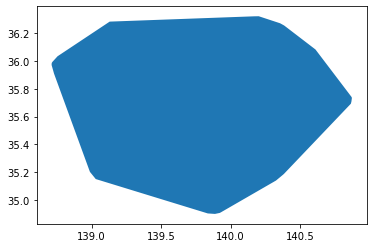

In [17]:
survey_area = gpd.read_file('demand_inputs/S05-a-10_SYUTO_GML/S05-a-10_SYUTO-g_Occurred_ConcentratedTrafficVolumeOfPersonTrip.shp')
survey_area = survey_area.set_crs(4326)
print(survey_area.to_crs(3857).unary_union.area)
survey_area_boundary = gpd.GeoSeries(survey_area.unary_union.convex_hull)
survey_area_boundary.plot()
plt.show()

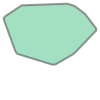

In [13]:
survey_area_boundary.iloc[0]

In [14]:
tokyo_graph = ox.graph_from_polygon(survey_area_boundary.iloc[0], network_type='drive')
tokyo_graph = ox.utils_graph.get_largest_component(tokyo_graph, strongly=True)
tokyo_nodes, tokyo_edges = ox.graph_to_gdfs(tokyo_graph)

NameError: name 'tokyo_node' is not defined

In [69]:
tokyo_nodes, tokyo_edges = ox.graph_to_gdfs(tokyo_graph)
print(tokyo_nodes.shape, tokyo_edges.shape)

(1244036, 6) (3464607, 20)


In [70]:
tokyo_nodes.to_csv('network_inputs/tokyo_nodes_osmnx_raw.csv', index=False)
tokyo_edges.to_csv('network_inputs/tokyo_edges_osmnx_raw.csv', index=False)

In [3]:
tokyo_nodes_raw = pd.read_csv('network_inputs/tokyo_nodes_osmnx_raw.csv')
tokyo_edges_raw = pd.read_csv('network_inputs/tokyo_edges_osmnx_raw.csv')
display(tokyo_nodes_raw.head(3))
display(tokyo_edges_raw.head(3))

/home/bingyu/anaconda3/envs/geo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,8,9,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,y,x,osmid,highway,ref,geometry
0,36.296069,139.713805,4395630592,NaN,NaN,POINT (139.7138052 36.2960693)
1,36.286796,139.711021,4395630603,NaN,NaN,POINT (139.7110211 36.2867956)
2,36.297458,139.714450,4395630616,NaN,NaN,POINT (139.7144501 36.2974579)


,osmid,highway,oneway,length,geometry,lanes,ref,name,width,maxspeed,bridge,tunnel,est_width,service,access,junction,area,u,v,key
0,441867543,residential,False,39.627,"LINESTRING (139.7138052 36.2960693, 139.713601...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4395630592,1780011919,0
1,166552472,unclassified,False,42.152,"LINESTRING (139.7110211 36.2867956, 139.710924...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4395630603,4395623880,0
2,166552472,unclassified,False,139.320,"LINESTRING (139.7110211 36.2867956, 139.711073...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4395630603,1780011985,0


In [14]:
np.sum(tokyo_edges_raw['length'])
print(np.sum(tokyo_edges_raw['oneway']==True),
np.sum(tokyo_edges_raw['oneway']==False), tokyo_edges_raw.shape)
print(127514+3238789)
print(np.sum(tokyo_edges_raw.loc[tokyo_edges_raw['oneway']==True, 'length'])+np.sum(tokyo_edges_raw.loc[tokyo_edges_raw['oneway']==False, 'length'])/2)

127514 3238789 (3464607, 20)
3366303
156694927.99050006


In [72]:
# reformat the columns
tokyo_nodes = tokyo_nodes_raw.copy()
tokyo_nodes['lon'] = tokyo_nodes['x']
tokyo_nodes['lat'] = tokyo_nodes['y']
tokyo_nodes['node_id'] = np.arange(tokyo_nodes.shape[0])
tokyo_nodes = tokyo_nodes[['node_id', 'osmid', 'lon', 'lat']].reset_index(drop=True)
node_osmid_id_dict = {getattr(n, 'osmid'): getattr(n,'node_id') for n in tokyo_nodes.itertuples()}
display(tokyo_nodes.head(3))

,node_id,osmid,lon,lat
0,0,4395630592,139.713805,36.296069
1,1,4395630603,139.711021,36.286796
2,2,4395630616,139.714450,36.297458


In [87]:
tokyo_edges = tokyo_edges_raw[['u', 'v', 'highway', 'length', 'lanes', 'maxspeed', 'geometry']].copy()
tokyo_edges['start_node_id'] = tokyo_edges['u'].map(node_osmid_id_dict)
tokyo_edges['end_node_id'] = tokyo_edges['v'].map(node_osmid_id_dict)

lanes_dict = {'motorway': 2, 'motorway_link': 2, 'trunk': 2, 'trunk_link': 2, 'primary': 2, 'primary_link': 2}
def fill_lanes(value):
    lanes = []
    if '[' in value: 
        value = value[1:-1].replace("'", "").replace(' ', '').split(',')
    else: value=[value]
    for v in value:
        if v in lanes_dict: lanes.append(lanes_dict[v])
        else: lanes.append(1)
    return(np.mean(lanes))

maxspeed_dict = {'motorway': 100, 'motorway_link': 100, 'trunk': 100, 'trunk_link': 100, 'primary': 60, 'primary_link': 60, 'secondary': 60, 'secondary_link': 60}
def fill_maxspeed(value):
    maxspeed = []
    if '[' in value: 
        value = value[1:-1].replace("'", "").replace(' ', '').split(',')
    else: value=[value]
    for v in value:
        if v in maxspeed_dict: maxspeed.append(maxspeed_dict[v])
        else: maxspeed.append(40)
    return(np.mean(maxspeed))

signal_dict = {'motorway': 1, 'motorway_link': 1, 'trunk': 1, 'trunk_link': 1}
def fill_signal(value):
    signal = []
    if '[' in value: 
        value = value[1:-1].replace("'", "").replace(' ', '').split(',')
    else: value=[value]
    for v in value:
        if v in signal_dict: signal.append(signal_dict[v])
        else: signal.append(0.5)
    return(np.max(signal))

def fill_type(value):
    if '[' in value: return 'multiple'
    else: return value

tokyo_edges['lanes'] = tokyo_edges['highway'].apply(fill_lanes)
tokyo_edges['maxspeed'] = tokyo_edges['highway'].apply(fill_maxspeed)
tokyo_edges['signal'] = tokyo_edges['highway'].apply(fill_signal)
tokyo_edges['type'] = tokyo_edges['highway'].apply(fill_type)
tokyo_edges['capacity'] = tokyo_edges['lanes']*1800*tokyo_edges['signal']
tokyo_edges['fft'] = tokyo_edges['length']/tokyo_edges['maxspeed']*3.6

display(tokyo_edges.head(3))
display(tokyo_edges.groupby('lanes').size())
display(tokyo_edges.groupby('maxspeed').size())
display(tokyo_edges.groupby('signal').size())
display(tokyo_edges.groupby('type').size())

,u,v,highway,length,lanes,maxspeed,geometry,start_node_id,end_node_id,signal,type,capacity,fft
0,4395630592,1780011919,residential,39.627,1.0,40.0,"LINESTRING (139.7138052 36.2960693, 139.713601...",0,456975,0.5,residential,900.0,3.56643
1,4395630603,4395623880,unclassified,42.152,1.0,40.0,"LINESTRING (139.7110211 36.2867956, 139.710924...",1,1242479,0.5,unclassified,900.0,3.79368
2,4395630603,1780011985,unclassified,139.320,1.0,40.0,"LINESTRING (139.7110211 36.2867956, 139.711073...",1,457019,0.5,unclassified,900.0,12.53880


lanes
1.000000    3307908
1.333333          2
1.500000         97
2.000000     156600
dtype: int64

maxspeed
40.000000     3213635
46.666667          10
50.000000         210
60.000000      195006
70.000000          25
80.000000          12
100.000000      55709
dtype: int64

signal
0.5    3408861
1.0      55746
dtype: int64

type
bus_guideway             2
bus_stop                 2
crossing                24
living_street        17398
motorway              1958
motorway_link         2637
multiple             17219
passing_place            4
planned                 12
primary              98881
primary_link          1999
residential        1534377
rest_area                2
road                   942
route                    2
secondary            93473
secondary_link         633
tertiary            396847
tertiary_link         1615
traffic_signals          4
trail                    4
trunk                48595
trunk_link            2470
unclassified       1245467
yes                     40
dtype: int64

In [88]:
tokyo_nodes.to_csv('network_inputs/tokyo_nodes.csv', index=False)
tokyo_edges.to_csv('network_inputs/tokyo_edges.csv', index=False)